<class 'networkx.utils.decorators.argmap'> compilation 8:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


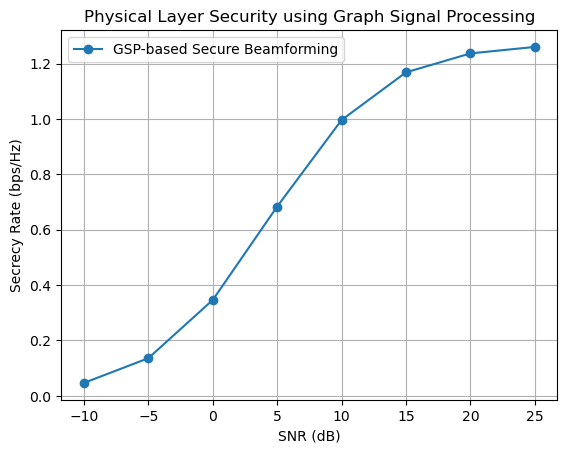

In [6]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.linalg import eigh
from sklearn.cluster import SpectralClustering

# Parameters
Nt = 4  # Transmit antennas
Nr = 2  # Bob's receive antennas
Ne = 2  # Eve's receive antennas
SNR_dB = np.arange(-10, 30, 5)  # SNR range in dB
num_nodes = 10  # Wireless nodes

# Generate random graph to model the wireless network
G = nx.erdos_renyi_graph(num_nodes, 0.5, seed=42)  # Random connectivity
L = nx.laplacian_matrix(G).toarray()  # Convert to dense NumPy array

# Compute Graph Fourier Transform (GFT)
eigvals, U = eigh(L)  # Eigen decomposition of Laplacian

# Ensure we only keep the first Nt eigenvectors (columns)
U_reduced = U[:, :Nt]  # Now shape is (10, 4)

# Generate random MIMO channels
H_bob = np.random.randn(Nr, Nt) / np.sqrt(2)  # Legitimate user channel
H_eve = np.random.randn(Ne, Nt) / np.sqrt(2)  # Eavesdropper channel

# Graph Spectral Filtering for Secure Beamforming
signal = np.random.randn(num_nodes)  # Random graph signal (transmitted power)
signal_filtered = U_reduced @ np.diag(np.exp(-np.diag(U_reduced.T @ L @ U_reduced))) @ U_reduced.T @ signal

# Spectral Clustering for Secure Node Selection
sc = SpectralClustering(n_clusters=2, affinity='precomputed', assign_labels='kmeans')
labels = sc.fit_predict(nx.to_numpy_array(G))  # Convert adjacency matrix properly
secure_nodes = np.where(labels == 0)[0]  # Cluster 0 as secure nodes

# Fix secure_nodes to have exactly Nt elements
if len(secure_nodes) < Nt:
    secure_nodes = np.random.choice(num_nodes, Nt, replace=False)  # Pick Nt random nodes
else:
    secure_nodes = secure_nodes[:Nt]  # Keep only Nt nodes

# Compute Secrecy Capacity
secrecy_rates = []
for snr_db in SNR_dB:
    snr = 10 ** (snr_db / 10)
    signal_power = 0.7 * snr
    noise_power = 0.3 * snr

    # Fix: Index rows (not columns) of U_reduced
    selected_U = U_reduced[secure_nodes, :]  # Correct shape: (Nt, Nt)

    signal_bob = np.linalg.norm(H_bob @ selected_U) ** 2 * signal_power
    noise_bob = Nr  # Assume normalized noise variance
    rate_bob = np.log2(1 + signal_bob / noise_bob)

    signal_eve = np.linalg.norm(H_eve @ selected_U) ** 2 * signal_power
    noise_eve = Ne
    rate_eve = np.log2(1 + signal_eve / noise_eve)

    secrecy_rate = max(rate_bob - rate_eve, 0)  # Ensure non-negative secrecy rate
    secrecy_rates.append(secrecy_rate)

# Plot Secrecy Rate vs. SNR
plt.plot(SNR_dB, secrecy_rates, marker='o', label='GSP-based Secure Beamforming')
plt.xlabel("SNR (dB)")
plt.ylabel("Secrecy Rate (bps/Hz)")
plt.title("Physical Layer Security using Graph Signal Processing")
plt.legend()
plt.grid()
plt.show()
